In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

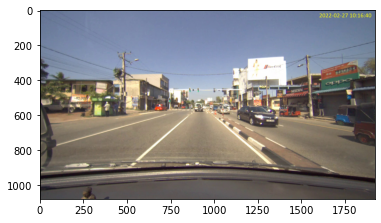

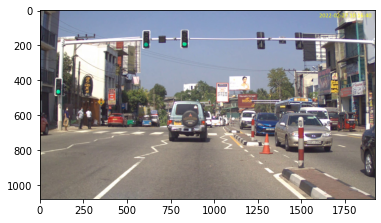

In [24]:
wide_img = cv2.imread('wide_t1_018.jpg')
wide_img = cv2.cvtColor(wide_img, cv2.COLOR_BGR2RGB)
plt.imshow(wide_img)
plt.show()

narrow_img = cv2.imread('narrow_t1_018.jpg')
narrow_img = cv2.cvtColor(narrow_img, cv2.COLOR_BGR2RGB)
plt.imshow(narrow_img)
plt.show()


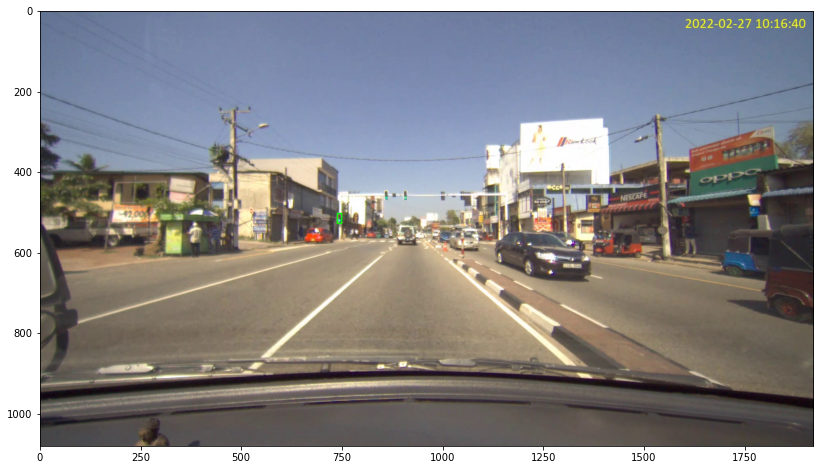

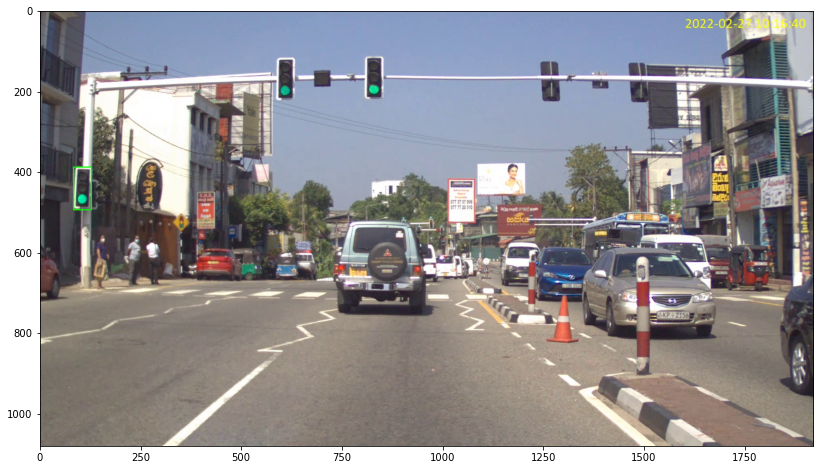

In [25]:
wide_x1,wide_y1, wide_x2, wide_y2 = 737,502,748,527 


rect_wide=cv2.rectangle(wide_img,(wide_x1,wide_y1),(wide_x2,wide_y2),(0,255,0),2)
plt.figure(figsize = (20,8))
plt.imshow(rect_wide)

##### narrow
narrow_x1,narrow_y1, narrow_x2, narrow_y2 = 83,387,127,493

rect_narrow=cv2.rectangle(narrow_img,(narrow_x1,narrow_y1),(narrow_x2,narrow_y2),(0,255,0),2)
plt.figure(figsize = (20,8))
plt.imshow(rect_narrow)





# Undistortion narrow camera

In [34]:
camera = 'narrow'

cam_details_file = camera+'_calibration_data\ost.txt'
homograpy_mtx_file = 'homography_matrix.txt'
# cam_details_file = 'cal_'+camera+'_edited.yml'

camera_matrix_raw = 15
distortion_raw = 20
rectification_raw = 23
projection_raw = 27

w,h = 1920,1080

camera_mtx_narrow = np.loadtxt(cam_details_file, dtype=np.float32, skiprows=camera_matrix_raw-1, max_rows=3, delimiter=' ')
dist_coff_narrow = np.loadtxt(cam_details_file, dtype=np.float32, skiprows=distortion_raw-1,max_rows=1, delimiter=' ')
newcameramtx_narrow, roi = cv2.getOptimalNewCameraMatrix(camera_mtx_narrow, dist_coff_narrow, (w,h), 1, (w,h))
homograpy_mtx = np.loadtxt(homograpy_mtx_file, dtype=np.float32)
# print(homograpy_mtx)

# print(camera_mtx_narrow, dist_coff_narrow)


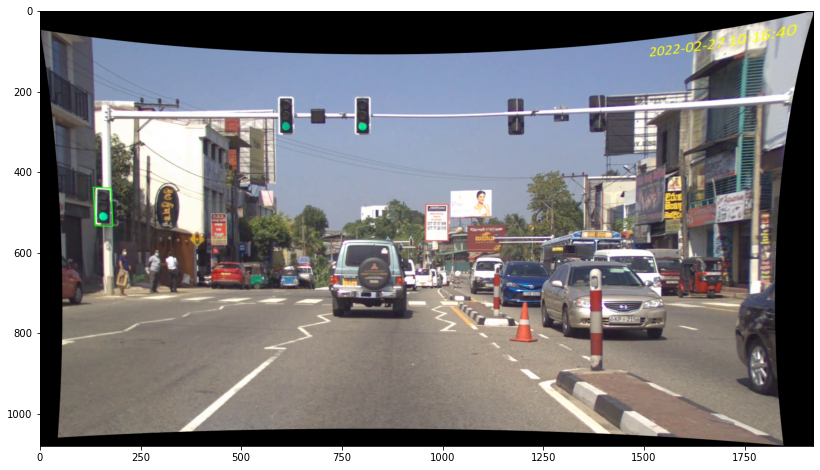

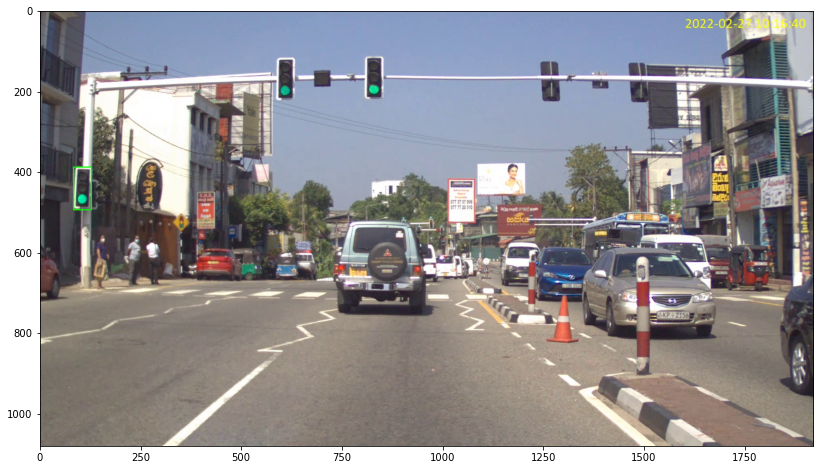

In [44]:
narrow_img_undist = cv2.undistort(narrow_img, camera_mtx_narrow, dist_coff_narrow, None, newcameramtx_narrow)
# x, y, w, h = roi
# dst = dst[y:y+h, x:x+w]

plt.figure(figsize = (20,8))
plt.imshow(narrow_img_undist)
plt.show()

plt.figure(figsize = (20,8))
plt.imshow(narrow_img)

## undistort narrow bbox coordinates

In [36]:
narrow_box_cords = np.array([[narrow_x1,narrow_y1], [narrow_x2, narrow_y2]], dtype=np.float32)
print(narrow_box_cords.shape)
narrow_undist_cords =  cv2.undistortPoints(narrow_box_cords,camera_mtx_narrow,dist_coff_narrow,P=newcameramtx_narrow)
narrow_undist_cords = narrow_undist_cords.astype(int)
print(narrow_box_cords)
print(narrow_undist_cords)
print(narrow_undist_cords.shape)

(2, 2)
[[ 83. 387.]
 [127. 493.]]
[[[131 437]]

 [[179 534]]]
(2, 1, 2)


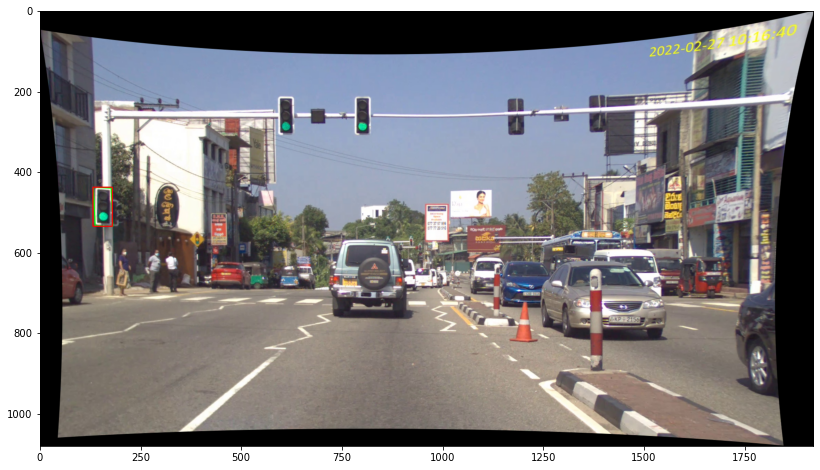

In [37]:
# rect_narrow_undist=cv2.rectangle(narrow_img_undist,(868,626),(1061,799),(0,0,255),2)
rect_narrow_undist=cv2.rectangle(narrow_img_undist,(narrow_undist_cords[0][0][0],narrow_undist_cords[0][0][1]),(narrow_undist_cords[1][0][0],narrow_undist_cords[1][0][1]),(255,0,0),2)
plt.figure(figsize = (20,8))
plt.imshow(rect_narrow_undist)

In [38]:
narrow_undist_cords = np.float32(narrow_undist_cords).reshape(-1,1,2)
wide_undist_cords = cv2.perspectiveTransform(narrow_undist_cords,homograpy_mtx)
wide_undist_cords = wide_undist_cords.astype(int)

print(wide_undist_cords)

[[[755 514]]

 [[765 535]]]


# calc homograpy

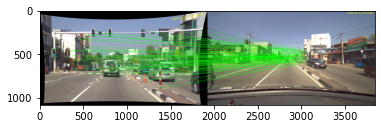

In [46]:

def calc_homograpy(narrow_img, wide_img, MIN_MATCH_COUNT):

    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(narrow_img,None)
    kp2, des2 = sift.detectAndCompute(wide_img,None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)


    #######################
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        # print(M)
        matchesMask = mask.ravel().tolist()

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
        img3 = cv2.drawMatches(narrow_img,kp1,wide_img,kp2,good,None,**draw_params)
        plt.imshow(img3, 'gray'),plt.show()

    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None


    return M

homograpy_mtx = calc_homograpy(narrow_img_undist, wide_img, MIN_MATCH_COUNT=10)

# undistort wide camera

In [39]:
camera = 'wide'

cam_details_file = camera+'_calibration_data\ost.txt'

camera_matrix_raw = 15
distortion_raw = 20
rectification_raw = 23
projection_raw = 27

w,h = 1920,1080

camera_mtx_wide = np.loadtxt(cam_details_file, dtype=np.float32, skiprows=camera_matrix_raw-1, max_rows=3, delimiter=' ')
dist_coff_wide = np.loadtxt(cam_details_file, dtype=np.float32, skiprows=distortion_raw-1,max_rows=1, delimiter=' ')
newcameramtx_wide, roi = cv2.getOptimalNewCameraMatrix(camera_mtx_wide, dist_coff_wide, (w,h), 1, (w,h))

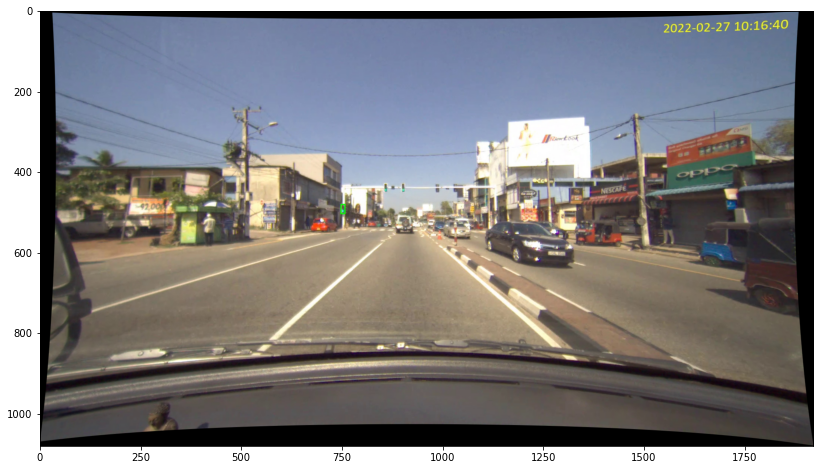

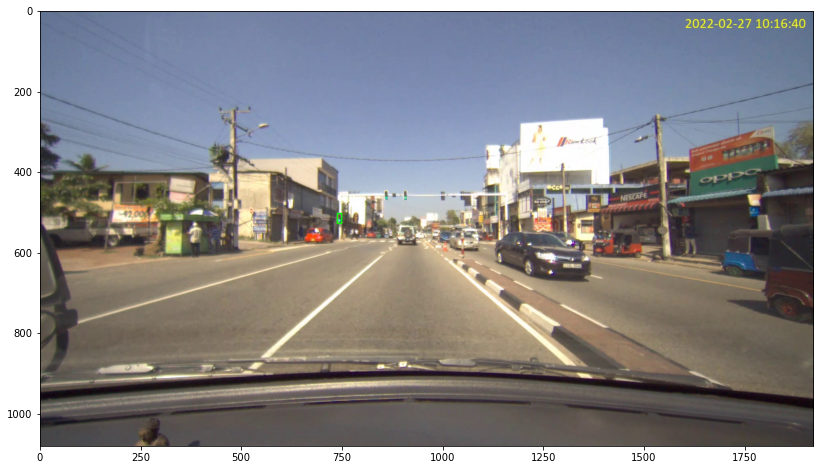

In [40]:
wide_img_undist = cv2.undistort(wide_img, camera_mtx_wide, dist_coff_wide, None, newcameramtx_wide)

plt.figure(figsize = (20,8))
plt.imshow(wide_img_undist)
plt.show()

plt.figure(figsize = (20,8))
plt.imshow(wide_img)

In [41]:
print(wide_undist_cords)

[[[755 514]]

 [[765 535]]]


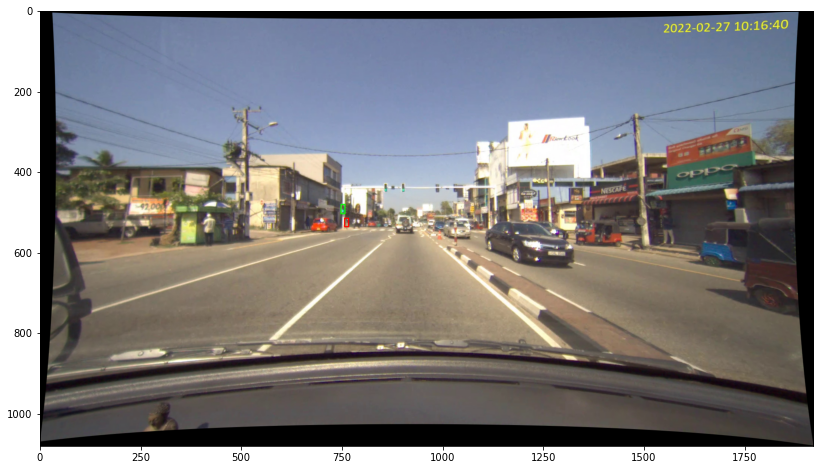

In [42]:
rect_wide_undist=cv2.rectangle(wide_img_undist,(wide_undist_cords[0][0][0],wide_undist_cords[0][0][1]),(wide_undist_cords[1][0][0],wide_undist_cords[1][0][1]),(255,0,0),2)

plt.figure(figsize = (20,8))
plt.imshow(rect_wide_undist)

In [13]:
def Distort(x_cord, y_cord, camera_matrix, distort):
    # // To relative coordinates <- this is the step you are missing.
    
    k1,k2,p1,p2,k3 = distort

    fx = camera_matrix[0][0]
    fy = camera_matrix[1][1]
    cx = camera_matrix[0][2]
    cy = camera_matrix[1][2]

    x = (x_cord - cx) / fx
    y = (y_cord - cy) / fy

    r2 = x*x + y*y

    # // Radial distorsion
    xDistort = x * (1 + k1 * r2 + k2 * r2 * r2 + k3 * r2 * r2 * r2)
    yDistort = y * (1 + k1 * r2 + k2 * r2 * r2 + k3 * r2 * r2 * r2)

    # // Tangential distorsion
    xDistort = xDistort + (2 * p1 * x * y + p2 * (r2 + 2 * x * x))
    yDistort = yDistort + (p1 * (r2 + 2 * y * y) + 2 * p2 * x * y)

    # // Back to absolute coordinates.
    xDistort = xDistort * fx + cx
    yDistort = yDistort * fy + cy

    return xDistort, yDistort

In [14]:
wide_dist_cords = []
map1 =[]
map2 = []
map1, map2 = cv2.initUndistortRectifyMap(camera_mtx_wide, dist_coff_wide, newCameraMatrix= newcameramtx_wide, R=np.eye(3,dtype=int), size=(1080,1920), m1type=cv2.CV_32FC1)

wide_undist_cords = wide_undist_cords.astype(int)
for i in wide_undist_cords:
    wide_dist_cords.append([map2[i[0][0]][i[0][1]],map1[i[0][0]][i[0][1]]])

wide_dist_cords = np.array(wide_dist_cords).astype(int)

print(wide_dist_cords)
# wide_distcv2.InitUndistortRectifyMap(cameraMatrix, distCoeffs, R, newCameraMatrix, map1, map2)

[[ 958  499]
 [1004  544]]


In [15]:
map1[10][20]

-9.942164

In [16]:
wide_dist_cords = []
for i in wide_undist_cords:
    wide_dist_cords.append([Distort(i[0][0],i[0][1],newcameramtx_wide,dist_coff_wide)])

wide_dist_cords = np.array(wide_dist_cords).astype(int)

print(wide_dist_cords)

[[[912 520]]

 [[955 561]]]


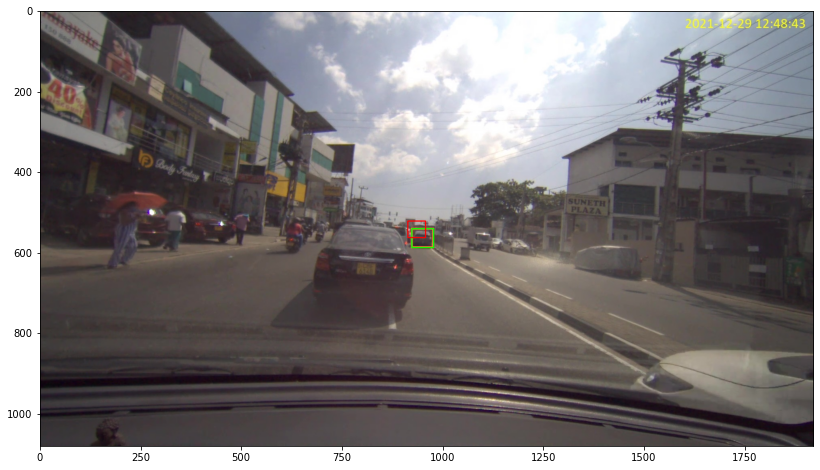

In [17]:


# rect_wide_dist=cv2.rectangle(wide_img,(wide_dist_cords[0][0][0],wide_dist_cords[0][0][1]),(wide_dist_cords[1][0][0],wide_dist_cords[1][0][1]),(255,0,0),2)
rect_wide_dist=cv2.rectangle(wide_img,(wide_undist_cords[0][0][0],wide_undist_cords[0][0][1]),(wide_undist_cords[1][0][0],wide_undist_cords[1][0][1]),(255,0,0),2)

plt.figure(figsize = (20,8))
plt.imshow(rect_wide_dist)

In [18]:
print(wide_undist_cords)

[[[912 521]]

 [[956 562]]]


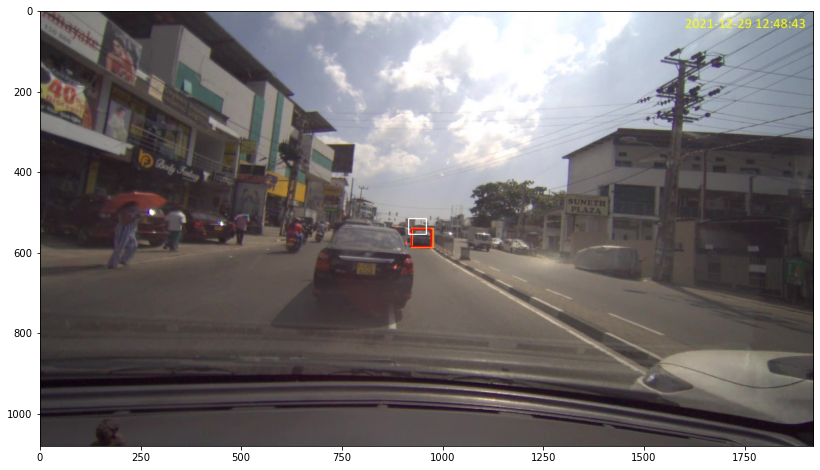

In [171]:

wide_undist_cords = wide_undist_cords.astype(np.float32)
wide_dist_cords_2 =  cv2.undistortPoints(wide_undist_cords,camera_mtx_wide,dist_coff_wide,P=newcameramtx_wide)


wide_dist_cords_2 = wide_dist_cords_2.astype(int)
rect_wide_dist=cv2.rectangle(wide_img,(wide_dist_cords_2[0][0][0],wide_dist_cords_2[0][0][1]),(wide_dist_cords_2[1][0][0],wide_dist_cords_2[1][0][1]),(255,255,255),2)

plt.figure(figsize = (20,8))
plt.imshow(rect_wide_dist)

In [172]:
narrow_dist_cords = []
for i in narrow_undist_cords:
    narrow_dist_cords.append([Distort(i[0][0],i[0][1],newcameramtx_narrow,dist_coff_narrow)])

narrow_dist_cords = np.array(narrow_dist_cords).astype(int)

print(narrow_dist_cords)

[[[ 868  624]]

 [[1060  797]]]


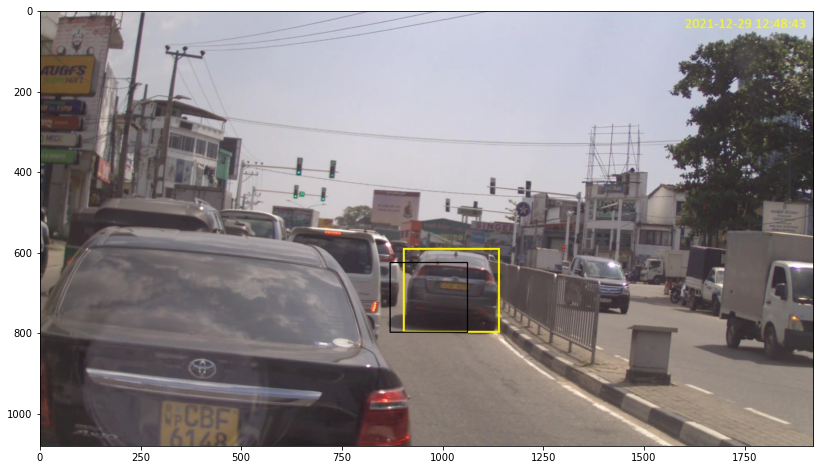

In [173]:
dist_narrow=cv2.rectangle(narrow_img,(narrow_dist_cords[0][0][0],narrow_dist_cords[0][0][1]),(narrow_dist_cords[1][0][0],narrow_dist_cords[1][0][1]),(0,0,0),2)

plt.figure(figsize = (20,8))
plt.imshow(dist_narrow)

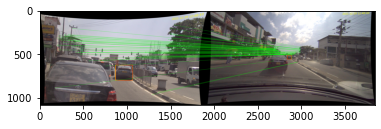

<class 'numpy.ndarray'> [[ 2.44748564e-01 -4.57570826e-02  7.19440066e+02]
 [ 1.12201453e-02  1.96178967e-01  3.79871100e+02]
 [ 2.03344990e-05 -5.08952962e-05  1.00000000e+00]]
(1080, 1920)


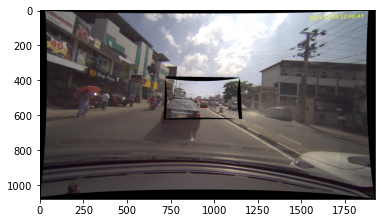

(<matplotlib.image.AxesImage at 0x1d98d88caf0>, None)

In [174]:
find_homograpy = True

MIN_MATCH_COUNT = 10
narrow_calibration_img = narrow_img_undist       # queryImage
wide_calibration_img = wide_img_undist# trainImage

narrow_img_color = narrow_img_undist         # queryImage
wide_img_color = wide_img_undist # trainImage

def calc_homograpy(narrow_img, wide_img, MIN_MATCH_COUNT):

    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(narrow_img,None)
    kp2, des2 = sift.detectAndCompute(wide_img,None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)


    #######################
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        # print(M)
        matchesMask = mask.ravel().tolist()

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
        img3 = cv2.drawMatches(narrow_img,kp1,wide_img,kp2,good,None,**draw_params)
        plt.imshow(img3, 'gray'),plt.show()

    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None


    return M


#################################

if (find_homograpy == True):

    M = calc_homograpy(narrow_calibration_img, wide_calibration_img, MIN_MATCH_COUNT)
    print(type(M),M)

    f = open('homography_matrix.txt','w')
    for i in range(3):
        for j in range(3):
            f.write(str(M[i][j])+' ')
        f.write('\n')
    # f.write(str(M))
    f.close()


# M = np.loadtxt('homography_matrix.txt', usecols=range(3))

h,w = narrow_img_color.shape[0:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
# wide_img = cv.polylines(wide_img,[np.int32(dst)],True,255,3, cv.LINE_AA)

# plt.imshow(narrow_img_color), plt.show()
warped_narrow_img = cv2.warpPerspective(narrow_img_color, M, ((narrow_img_color.shape[1]), wide_img_color.shape[0])) #wraped image

# plt.imshow(dst, 'gray'),plt.show()
dst_2 = np.squeeze(dst)
mask = np.zeros(wide_img_color.shape[0:2])
print(mask.shape)
cv2.fillPoly(mask,np.int32([dst_2]),1)
poly_copied = cv2.bitwise_and(warped_narrow_img,warped_narrow_img,mask = np.uint8(mask))
# plt.imshow(poly_copied, ),plt.show()

mask_inverse = np.ones(narrow_img_color.shape[0:2])
#assuming src1 and src2 are of same size
cv2.fillPoly(mask_inverse,np.int32([dst_2]),0)
img1_middle_removed = cv2.bitwise_and(wide_img_color,wide_img_color,mask = np.uint8(mask_inverse))

concatted_img = np.add(poly_copied,img1_middle_removed)
plt.imshow(concatted_img,),plt.show()
# cv2.imwrite("stitched_img.png",cv.cvtColor(concatted_img,cv.COLOR_RGB2BGR))